In [1]:
# Import libraries
import os
import glob
import pydicom as dicom
import numpy as np
import pandas as pd
import cv2

In [2]:
import torch
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.applications import InceptionResNetV2
from keras.utils import plot_model

In [3]:
# Import custom definitions
from definitions import *

print(f"Dataset path: {data_root}")
print(f"Meta path: {meta_path}")
print(f"Mass training data path: {new_mass_train_path}")
print(f"Mass test data path: {new_mass_test_path}")
print(f"Mass train tensor path: {mass_train_tensor_path}")
print(f"Mass test tensor path: {mass_test_tensor_path}")

Dataset path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688
Meta path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\metadata.csv
Mass training data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_train_set.csv
Mass test data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_test_set.csv
Mass train tensor path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\mass_tensor\train
Mass test tensor path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\mass_tensor\test


# datasets

In [4]:
# Load updated mass datasets
new_mass_train = pd.read_csv(new_mass_train_path)
new_mass_test = pd.read_csv(new_mass_test_path)

In [5]:
print(new_mass_train.shape)
new_mass_train.head(2)

(1318, 14)


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC\07-20-2016-DDSM-...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO\07-20-2016-DDSM...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...


In [6]:
print(new_mass_test.shape)
new_mass_test.head(2)

(378, 14)


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC\10-04-2016-DDSM-NA-3...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO\10-04-2016-DDSM-NA-...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...


### Extract pixel data from dicom files

In [7]:
def image_processor(image_path, target_size):
    path = os.path.join(data_root,'CBIS-DDSM', image_path)
    ds = dicom.dcmread(path)
    ds = ds.pixel_array
    ds_2d = ds.astype(float)
    ds_2d_scaled = (np.maximum(ds_2d, 0) / ds_2d.max()) * 255.0
    ds_2d_scaled = np.uint8(ds_2d_scaled)
    ds_2d_scaled = cv2.cvtColor(ds_2d_scaled, cv2.COLOR_BGR2RGB)
    ds_resized = tf.image.resize(ds_2d_scaled, (128, 128))
    ds_cast = tf.cast(ds_resized, tf.float32) / 255.0
    return ds_cast

def mask_processor(image_path, target_size):
    path = os.path.join(data_root,'CBIS-DDSM', image_path)
    ds = dicom.dcmread(path)
    ds = ds.pixel_array

    # Scaling
    ds_2d = ds.astype(float)
    ds_2d_scaled = (np.maximum(ds_2d, 0) / ds_2d.max())

    ds_2d_scaled = np.uint8(ds_2d_scaled)
    ds_2d_scaled = cv2.cvtColor(ds_2d_scaled, cv2.COLOR_BGR2RGB)
    ds_resized = tf.image.resize(
        ds_2d_scaled, (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:, :, 1]

    # Ensure final dtype is float32 for the model
    ds_cast = tf.cast(ds_resized, tf.float32)

    # Explicitly ensure shape (128, 128, 1) by adding a channel dimension if it somehow got lost
    if ds_cast.shape.ndims == 2: # If it's (H, W)
        ds_cast = tf.expand_dims(ds_cast, axis=-1) # Make it (H, W, 1)

    ds_cast = tf.squeeze(ds_cast, axis=-1)
    return ds_cast
    
def load_image(input_image, input_mask, target_size):
    input_image = image_processor(input_image, target_size)
    input_mask = mask_processor(input_mask, target_size)
    return input_image, input_mask

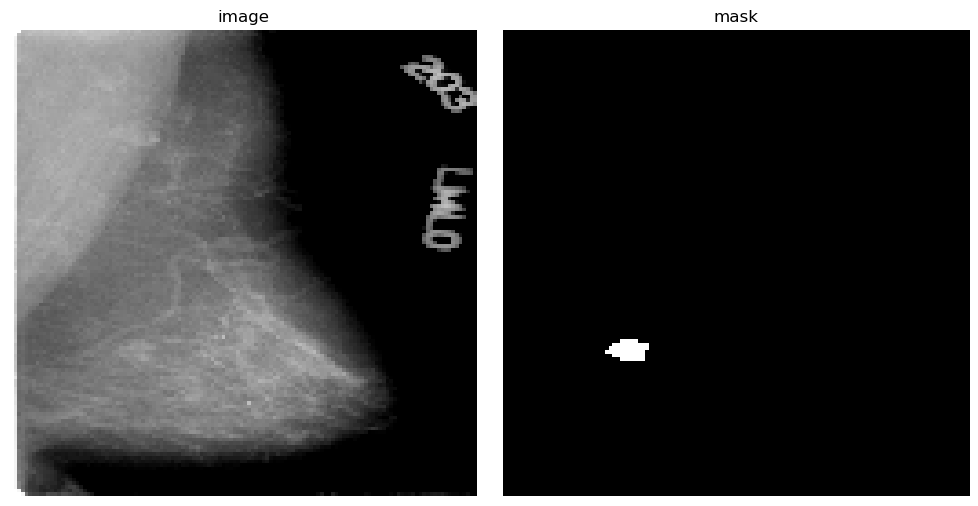

image shape: (128, 128, 3), dtype: <dtype: 'float32'>
mask shape: (128, 128), dtype: <dtype: 'float32'>


In [8]:
# Test
import matplotlib.pyplot as plt

image_path = r"C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\CBIS-DDSM\Mass-Training_P_02092_LEFT_MLO\07-20-2016-DDSM-NA-65216\1.000000-full mammogram images-91615\1-1.dcm"
mask_path = r"C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\CBIS-DDSM\Mass-Training_P_02092_LEFT_MLO_1\07-21-2016-DDSM-NA-14412\1.000000-ROI mask images-30086\1-1.dcm"

# Display
image_data = image_processor(image_path, target_size)
mask_data = mask_processor(mask_path, target_size)

labels = ['image', 'mask']
images = [image_data, mask_data]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for index in range(len(images)):
    # Render the image on the current axis
    ax = axes[index]
    ax.imshow(images[index], cmap='gray')    
    ax.set_title(labels[index])
    ax.axis('off')
    ax.grid(True)
# Display the subplot
plt.tight_layout()
plt.show()

print(f"image shape: {image_data.shape}, dtype: {image_data.dtype}")
print(f"mask shape: {mask_data.shape}, dtype: {mask_data.dtype}")

In [9]:
np.unique(mask_data.numpy())

array([0., 1.], dtype=float32)

In [10]:
process_train = False
process_test = False

BATCH_SIZE = 64
BUFFER_SIZE = 1000

target_train_rows = new_mass_train.shape[0]
target_test_rows = new_mass_test.shape[0]
target_mass_train = new_mass_train[: target_train_rows]
target_mass_test = new_mass_test[: target_test_rows]

In [11]:
train_images = None
if process_train:
    train_images = tf.data.Dataset.from_tensor_slices((
        list(map(lambda x: image_processor(x, target_size), target_mass_train['image file path'])),
        list(map(lambda x: mask_processor(x, target_size), target_mass_train['ROI mask file path']))
    ))#.batch(BATCH)
    #torch.save(train_images, mass_train_tensor_path)
    tf.data.Dataset.save(train_images, mass_train_tensor_path)
else:
    #train_images = torch.load(mass_train_tensor_path)
    train_images = tf.data.Dataset.load(mass_train_tensor_path)
for x, y in train_images.take(1):
    print(f"train image shape: {x.shape}, {y.shape}")

train image shape: (128, 128, 3), (128, 128)


In [12]:
test_images = None
if process_test:
    test_images = tf.data.Dataset.from_tensor_slices((
        list(map(lambda x: image_processor(x, target_size), target_mass_test['image file path'])),
        list(map(lambda x: mask_processor(x, target_size), target_mass_test['ROI mask file path']))
    ))
    #torch.save(test_images, mass_test_tensor_path)
    tf.data.Dataset.save(test_images, mass_test_tensor_path)
else:
    #test_images = torch.load(mass_test_tensor_path)
    test_images = tf.data.Dataset.load(mass_test_tensor_path)
for x, y in test_images.take(1):
    print(f"test image shape: {x.shape}, {y.shape}")

test image shape: (128, 128, 3), (128, 128)


In [14]:
test_rows = len(test_images)
val_size = int(0.8 * test_rows)
test_size = test_rows - val_size
print(f"Number of test_images: {test_rows}")
print(f"Validation data size: {val_size}")
print(f"Test batch size: {test_size}")

train_batches = train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_images.take(val_size).batch(BATCH_SIZE)
test_batches = test_images.skip(val_size).take(test_size).batch(BATCH_SIZE)

Number of test_images: 378
Validation data size: 302
Test batch size: 76


# CNN Architecture

### Model architecture and training

In [15]:
def downsample_block(x, n_filters, padding):
    f = double_conv_block(x, n_filters, padding)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters, padding):
    # upsample
    x = layers.Conv2DTranspose(
        filters=n_filters, kernel_size=3, strides=2, padding=padding,
        activation=tf.keras.activations.relu)(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters, padding)
    return x
    
def double_conv_block(x, n_filters, padding):
    # Conv2D then ReLU activation
    # params:
    #   kernel_initializer: define the way to set the initial random weights of Keras layers
    x = layers.Conv2D(
        filters=n_filters, kernel_size=3, padding=padding, 
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.HeNormal)(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(
        filters=n_filters, kernel_size=3, padding=padding, 
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.HeNormal)(x)
    return x

In [16]:
def build_modified_unet_model():
    model = None
    try:
        inputs = layers.Input(shape=target_size)
    
        f = [64, 128, 256, 512, 1024]
        padding = "same"
    
        # Encoder - Downsampling path
        f1, p1 = downsample_block(inputs, f[0], padding)
        f2, p2 = downsample_block(p1, f[1], padding)
        f3, p3 = downsample_block(p2, f[2], padding)
        f4, p4 = downsample_block(p3, f[3], padding)
    
        # Bottleneck
        bottleneck = double_conv_block(p4, f[4], padding)
    
        # Decoder - Upsampling path
        u6 = upsample_block(bottleneck, f4, f[3], padding)
        u7 = upsample_block(u6, f3, f[2], padding)
        u8 = upsample_block(u7, f2, f[1], padding)
        u9 = upsample_block(u8, f1, f[0], padding)
    
        # Output layer
        outputs = layers.Conv2D(
            filters=3, kernel_size=1, padding=padding,
            activation=tf.keras.activations.softmax)(u9)
    
        # Model
        model = tf.keras.Model(inputs, outputs, name="U-Net")
    except Exception as ex:
        print(f"\nError caught: {ex}")
    finally:
        return model

In [27]:
NUM_EPOCHS = 5
VAL_SUBSPLITS = 5

STEPS_PER_EPOCH = len(train_images) // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE #// VAL_SUBSPLITS

print(f"epochs: {NUM_EPOCHS}")
print(f"batch size: {BATCH_SIZE}")
print(f"steps per epoch: {STEPS_PER_EPOCH}")
print(f"val subsplits: {VAL_SUBSPLITS}")
print(f"validation steps: {VALIDATION_STEPS}")

epochs: 5
batch size: 64
steps per epoch: 20
val subsplits: 5
validation steps: 4


In [28]:
tf.debugging.enable_check_numerics()

model = build_modified_unet_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    # Loss function to minimise
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=["accuracy"])

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [29]:
# Stop training when a monitored metric has stopped improving
earlystop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)
# Reduce learning rate when a metric has stopped improving
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2, verbose=1)
callbacks=[earlystop, reduce_lr]

history = model.fit(
    train_batches.repeat(),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=callbacks)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 512s 24s/step - accuracy: 0.8411 - loss: 0.5080 - val_accuracy: 0.9950 - val_loss: 0.3042 - learning_rate: 1.0000e-04
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 477s 24s/step - accuracy: 0.9946 - loss: 0.0595 - val_accuracy: 0.9950 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 473s 24s/step - accuracy: 0.9951 - loss: 0.0327 - val_accuracy: 0.9950 - val_loss: 0.1613 - learning_rate: 1.0000e-04
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 477s 24s/step - accuracy: 0.9949 - loss: 0.0311 - val_accuracy: 0.9950 - val_loss: 0.1636 - learning_rate: 1.0000e-04
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9948 - loss: 0.0296  
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 479s 24s/step - accuracy: 0.9948 - loss: 0.0296 - val_accuracy: 0.9950 - val_loss: 0.1795 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.


In [33]:
# Save the entire model
#model_path = os.path.join(data_root, 'model.h5')
#tf.keras.models.save_model(
#    model, model_path, overwrite=True, include_optimizer=True)

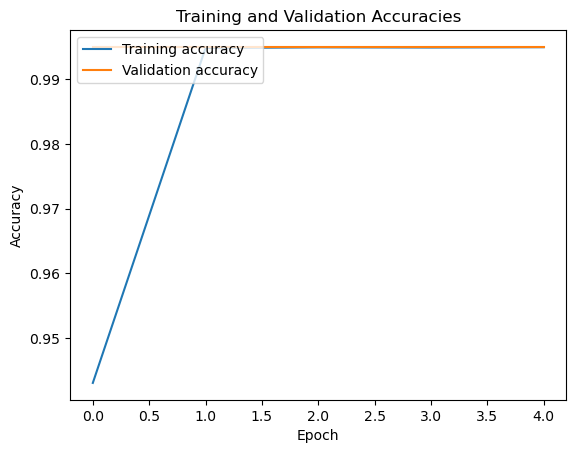

In [34]:
# Visualise model history: Accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

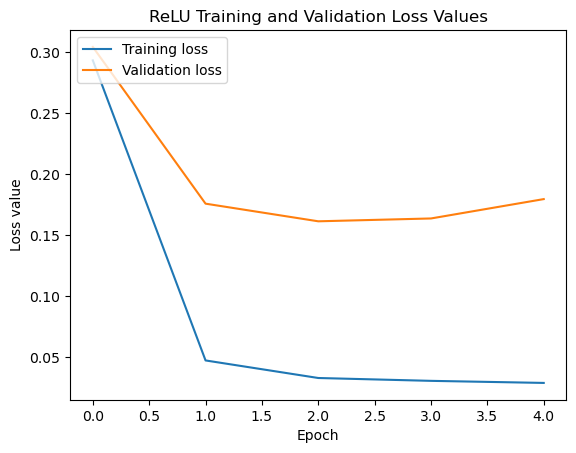

In [35]:
# Visualise model history: Loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('ReLU Training and Validation Loss Values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()